In [295]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [296]:
root_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/medium'

In [297]:
# 113: PCA, 114: CNN, 117: Binary, 118: Ternary
keywords_to_include = ['232', '255', '256']
keywords_to_exclude = ['delta', 'repeat']

In [298]:
def csvs_to_dfs():
    file_names = os.listdir(root_dir_path)
    file_names.sort()
    file_paths = [os.path.join(root_dir_path, file_name) for file_name in file_names if file_name.endswith('.csv')]
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        # Filter out rows based on keywords
        if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude):
            dfs.append(df)

    model_names = []
    for file_name in file_names:
        if any(keyword in file_name for keyword in keywords_to_include) and not any(keyword in file_name for keyword in keywords_to_exclude):
            # drop '.csv' from file name
            file_name = file_name.split('.csv')[0]
            splits = file_name.split('_')
            
            model_name = '_'.join(splits[0:2]+splits[-2:])
            model_names.append(model_name)

    file_paths = [file_path for file_path in file_paths if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude)]
    return model_names, file_paths, dfs

def get_stat(df):
    return df['Time'].sum(), df['VUS-PR'].mean()
    

In [299]:
model_names, file_paths, dfs = csvs_to_dfs()

In [300]:
print('model_names:', model_names)

model_names: ['SpikeCNN_232_Tenc64_OXOO', 'SpikeCNN_255_full_OXOO-BF-TC-neuron', 'SpikeCNN_256_full_OXOO-TC-neuron']


In [301]:
print('file_paths:', file_paths)

file_paths: ['/home/hwkang/dev-TSB-AD/TSB-AD/eval/medium/SpikeCNN_232_dynamic_receptive_s20_dre_Tenc64_OXOO.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/eval/medium/SpikeCNN_255_dynamic_receptive_s20_full_OXOO-BF-TC-neuron.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/eval/medium/SpikeCNN_256_dynamic_receptive_s20_full_OXOO-TC-neuron.csv']


In [302]:
ranking = []
for model_name, df in zip(model_names, dfs):
    total_runtime, mean_score = get_stat(df)
    print(f'{model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    ranking.append((model_name, total_runtime, mean_score))

print('\nranking (sorted by score):')
ranking.sort(key=lambda x: x[2], reverse=True)
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    # only top-5
    if i < 10:
        print(f'{i+1}. {model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    else:
        break

print('\nranking (sorted by runtime):')
ranking.sort(key=lambda x: x[1])
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    if i < 19:    
        print(f'{i+1}. {model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    else:
        break

SpikeCNN_232_Tenc64_OXOO: score: 0.3714, runtime: 2646.63, efficiency: 1.4032e-04
SpikeCNN_255_full_OXOO-BF-TC-neuron: score: 0.3592, runtime: 2262.66, efficiency: 1.5876e-04
SpikeCNN_256_full_OXOO-TC-neuron: score: 0.3656, runtime: 2348.07, efficiency: 1.5571e-04

ranking (sorted by score):
1. SpikeCNN_232_Tenc64_OXOO: score: 0.3714, runtime: 2646.63, efficiency: 1.4032e-04
2. SpikeCNN_256_full_OXOO-TC-neuron: score: 0.3656, runtime: 2348.07, efficiency: 1.5571e-04
3. SpikeCNN_255_full_OXOO-BF-TC-neuron: score: 0.3592, runtime: 2262.66, efficiency: 1.5876e-04

ranking (sorted by runtime):
1. SpikeCNN_255_full_OXOO-BF-TC-neuron: score: 0.3592, runtime: 2262.66, efficiency: 1.5876e-04
2. SpikeCNN_256_full_OXOO-TC-neuron: score: 0.3656, runtime: 2348.07, efficiency: 1.5571e-04
3. SpikeCNN_232_Tenc64_OXOO: score: 0.3714, runtime: 2646.63, efficiency: 1.4032e-04


In [303]:
def plot_performance_heatmap(metric='VUS-PR',
                             red_files=None,
                             highlight_only: bool = False):
    # red_files: ['110','115','65'] 처럼 파일명에 매칭될 키워드 리스트
    if red_files is None:
        red_files = []

    # --- 기존 로직 그대로 ---
    dataframes_dict = {}
    for fp, model_name in zip(file_paths, model_names):
        dataframes_dict[model_name] = pd.read_csv(fp)

    datasets = sorted({f for df in dataframes_dict.values() for f in df['file']})
    comparison_data = []
    for dataset in datasets:
        row = {'Dataset': dataset}
        for model, df in dataframes_dict.items():
            sel = df[df['file'] == dataset]
            row[model] = sel[metric].values[0] if not sel.empty else np.nan
        comparison_data.append(row)
    comparison_df = pd.DataFrame(comparison_data).set_index('Dataset')
    comparison_df.loc['Mean'] = comparison_df.mean()

    # highlight_only 가 True 면 red_files 에 포함된 데이터만 남김
    if highlight_only and red_files:
        comparison_df = comparison_df.loc[
            comparison_df.index.isin(red_files)
        ]
        comparison_df.loc['Mean'] = comparison_df.mean()

    # --- heatmap 그리기 ---
    plt.figure(figsize=(12, len(comparison_df) * 0.3))
    ax = sns.heatmap(
        comparison_df,
        annot=True, fmt='.3f', cmap='viridis',
        cbar_kws={'label': metric}
    )
    plt.title(f'Comparison of {metric} Across Models')
    if len(file_paths) >= 3:
        plt.xticks(rotation=45, ha='right')

    # --- y축 레이블 하이라이트 (highlight_only=False 일 때만 적용) ---
    if not highlight_only and red_files:
        for lbl in ax.get_yticklabels():
            txt = lbl.get_text()
            if any(key == txt or key in txt for key in red_files):
                lbl.set_color('red')

    plt.tight_layout()
    return comparison_df

,SpikeCNN_232_Tenc64_OXOO,SpikeCNN_255_full_OXOO-BF-TC-neuron,SpikeCNN_256_full_OXOO-TC-neuron
Dataset,,,
014_MSL_id_13_Sensor_tr_1525_1st_4575.csv,0.127697,0.127204,0.128544
017_MSL_id_16_Sensor_tr_512_1st_1850.csv,0.225869,0.226133,0.226798
025_MITDB_id_7_Medical_tr_37500_1st_88864.csv,0.583122,0.596759,0.521871
065_SMD_id_9_Facility_tr_737_1st_837.csv,0.642419,0.658087,0.643497
073_SMD_id_17_Facility_tr_5926_1st_10620.csv,0.404827,0.403470,0.417257
074_SMD_id_18_Facility_tr_7174_1st_21230.csv,0.249888,0.247074,0.245084
078_SMD_id_22_Facility_tr_500_1st_326.csv,0.722538,0.725855,0.721390
079_LTDB_id_1_Medical_tr_3618_1st_3718.csv,0.600944,0.567356,0.584357
087_SVDB_id_4_Medical_tr_5421_1st_5521.csv,0.427762,0.381275,0.433747


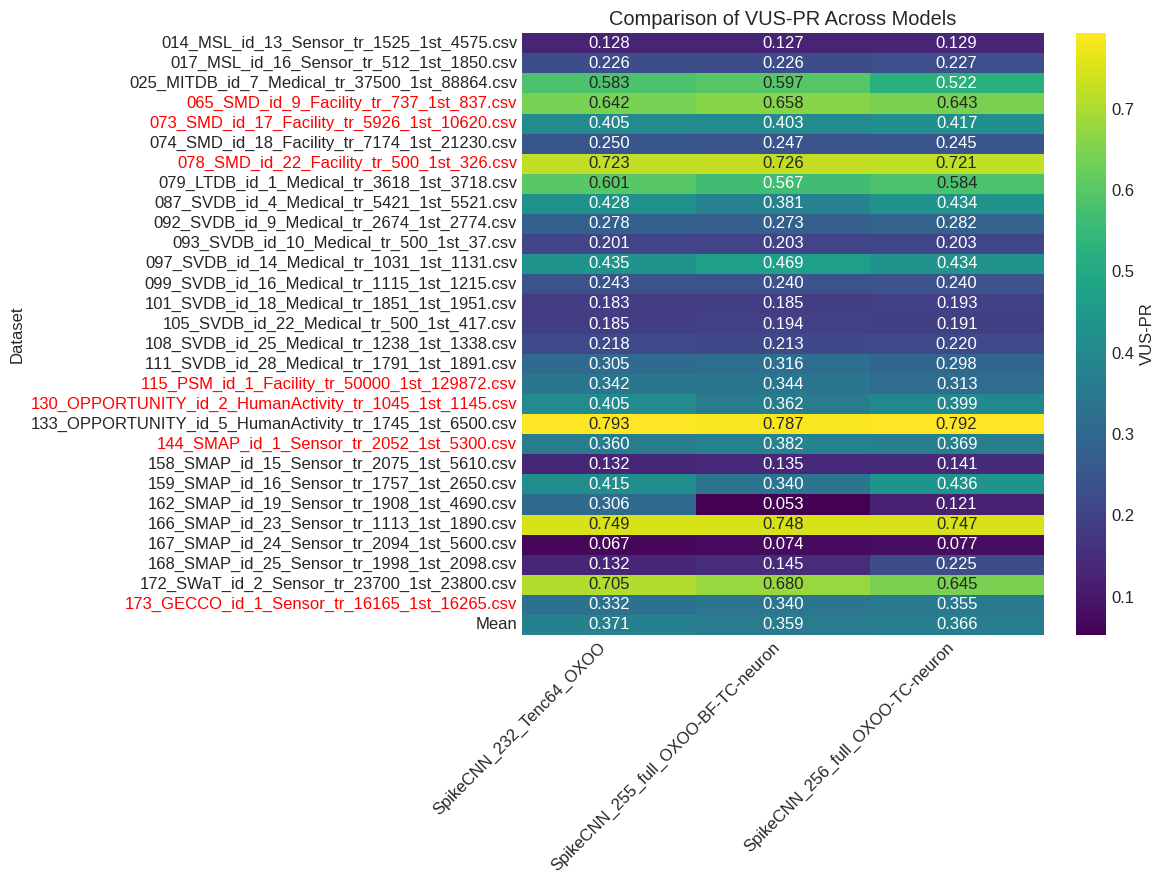

In [304]:
red_files = [
    '065_SMD_id_9_Facility_tr_737_1st_837.csv',
    '073_SMD_id_17_Facility_tr_5926_1st_10620.csv',
    '078_SMD_id_22_Facility_tr_500_1st_326.csv',
    '115_PSM_id_1_Facility_tr_50000_1st_129872.csv',
    '130_OPPORTUNITY_id_2_HumanActivity_tr_1045_1st_1145.csv',
    '144_SMAP_id_1_Sensor_tr_2052_1st_5300.csv',
    '173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv',
]
blue_files = [
    '014_MSL_id_13_Sensor_tr_1525_1st_4575.csv',
    '017_MSL_id_16_Sensor_tr_512_1st_1850.csv',
    '025_MITDB_id_7_Medical_tr_37500_1st_88864.csv',
    '074_SMD_id_18_Facility_tr_7174_1st_21230.csv',
    '079_LTDB_id_1_Medical_tr_3618_1st_3718.csv',
    '087_SVDB_id_4_Medical_tr_5421_1st_5521.csv',
    '092_SVDB_id_9_Medical_tr_2674_1st_2774.csv',
    '093_SVDB_id_10_Medical_tr_500_1st_37.csv',
    '097_SVDB_id_14_Medical_tr_1031_1st_1131.csv',
    '099_SVDB_id_16_Medical_tr_1115_1st_1215.csv',
    '101_SVDB_id_18_Medical_tr_1851_1st_1951.csv',
    '105_SVDB_id_22_Medical_tr_500_1st_417.csv',
    '108_SVDB_id_25_Medical_tr_1238_1st_1338.csv',
    '111_SVDB_id_28_Medical_tr_1791_1st_1891.csv',
    '133_OPPORTUNITY_id_5_HumanActivity_tr_1745_1st_6500.csv',
    '158_SMAP_id_15_Sensor_tr_2075_1st_5610.csv',
    '159_SMAP_id_16_Sensor_tr_1757_1st_2650.csv',
    '162_SMAP_id_19_Sensor_tr_1908_1st_4690.csv',
    '166_SMAP_id_23_Sensor_tr_1113_1st_1890.csv',
    '167_SMAP_id_24_Sensor_tr_2094_1st_5600.csv',
    '168_SMAP_id_25_Sensor_tr_1998_1st_2098.csv',
    '172_SWaT_id_2_Sensor_tr_23700_1st_23800.csv',
]
plot_performance_heatmap(red_files=red_files, highlight_only=False)

/tmp/ipykernel_14598/3033953778.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


,SpikeCNN_232_Tenc64_OXOO,SpikeCNN_255_full_OXOO-BF-TC-neuron,SpikeCNN_256_full_OXOO-TC-neuron
Dataset,,,
065_SMD_id_9_Facility_tr_737_1st_837.csv,0.642419,0.658087,0.643497
073_SMD_id_17_Facility_tr_5926_1st_10620.csv,0.404827,0.403470,0.417257
078_SMD_id_22_Facility_tr_500_1st_326.csv,0.722538,0.725855,0.721390
115_PSM_id_1_Facility_tr_50000_1st_129872.csv,0.342207,0.343725,0.312990
130_OPPORTUNITY_id_2_HumanActivity_tr_1045_1st_1145.csv,0.405088,0.361653,0.398841
144_SMAP_id_1_Sensor_tr_2052_1st_5300.csv,0.359522,0.382352,0.369194
173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv,0.331799,0.340193,0.354888
Mean,0.458343,0.459334,0.459722


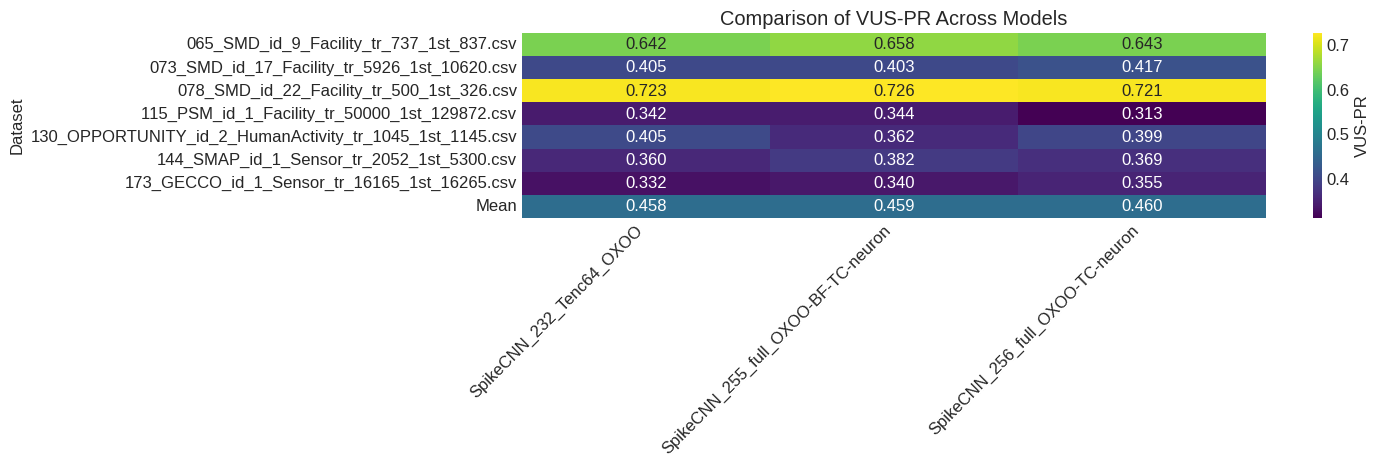

In [305]:
plot_performance_heatmap(red_files=red_files, highlight_only=True)